<a href="https://colab.research.google.com/github/kundajelab/rlsgkm/blob/master/examples/Demo_Regression_on_Simulated_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf lsgkm
!git clone https://github.com/kundajelab/rlsgkm.git
%cd rlsgkm
%cd src
!make
!make install
%cd /content

Cloning into 'rlsgkm'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 56 (delta 23), reused 33 (delta 9), pack-reused 0
Unpacking objects: 100% (56/56), done.
/content/rlsgkm
/content/rlsgkm/src
g++ -Wall -Wconversion -O3 -fPIC -c libsvm.cpp
g++ -Wall -Wconversion -O3 -fPIC -c libsvm_gkm.c
g++ -Wall -Wconversion -O3 -fPIC gkmtrain.c libsvm.o libsvm_gkm.o -o gkmtrain -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmpredict.c libsvm.o libsvm_gkm.o -o gkmpredict -lm -lpthread
g++ -Wall -Wconversion -O3 -fPIC gkmexplain.c libsvm.o libsvm_gkm.o -o gkmexplain -lm -lpthread
cp gkmtrain gkmpredict gkmexplain ../bin
/content


In [ ]:
#Grab some simulated data from another project

!wget https://raw.githubusercontent.com/kundajelab/feature_interactions/8f97332/data/train_neg_labels.txt.gz -O train_labels.txt.gz
!wget https://raw.githubusercontent.com/kundajelab/feature_interactions/8f97332/data/train_simulation.simdata.gz -O train_simulation.simdata.gz
!wget https://raw.githubusercontent.com/kundajelab/feature_interactions/8f97332/data/test_neg_labels.txt.gz -O test_labels.txt.gz
!wget https://raw.githubusercontent.com/kundajelab/feature_interactions/8f97332/data/test_simulation.simdata.gz -O test_simulation.simdata.gz

--2020-08-27 17:29:32--  https://raw.githubusercontent.com/kundajelab/feature_interactions/8f97332/data/train_neg_labels.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 523531 (511K) [application/octet-stream]
Saving to: ‘train_labels.txt.gz’

train_labels.txt.gz 100%[===================>] 511.26K  --.-KB/s    in 0.08s   

2020-08-27 17:29:33 (5.99 MB/s) - ‘train_labels.txt.gz’ saved [523531/523531]

--2020-08-27 17:29:33--  https://raw.githubusercontent.com/kundajelab/feature_interactions/8f97332/data/train_simulation.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP reque

In [ ]:
!gunzip -f *.gz

In [ ]:
def simdata_to_fasta(simdata_file, fa_file):
  with open(fa_file, 'w') as outf:
    for i, line in enumerate(open(simdata_file)):
      if i > 0:
        id, seq, _, _, _, _ = line.rstrip().split("\t")
        outf.write(">"+id+"\n")
        outf.write(seq+"\n")
  outf.close()

#prepare the fasta files for training/prediction
simdata_to_fasta("train_simulation.simdata", "train_simulation.fa")
simdata_to_fasta("test_simulation.simdata", "test_simulation.fa")

#For speed, only train on 5000 regions and test on 1000
!head -10000 train_simulation.fa > trimmed_train_simulation.fa
!head -2000 test_simulation.fa > trimmed_test_simulation.fa

#My label file had two columns - one for the label without noise and
# the other for the label with noise. I'll take the label with noise
# for training purposes.
#Also take the square root as that is a variance stabilizing transform for counts.
!perl -lane 'print sqrt($F[1])' train_labels.txt | head -5000 > nonoise_train_labels.txt
!perl -lane 'print sqrt($F[1])' test_labels.txt | head -1000 > nonoise_test_labels.txt

In [ ]:
#View labels file as a sanity check
!head nonoise_train_labels.txt

1.98888698355797
0.933996430516065
12.8789085363317
9.10575581881588
10.1229327709908
10.6211808979363
0.500560698879818
10.6358666611701
15.3549273800663
10.9921140650608


In [ ]:
#train the regression model
#-y 3 selects regression (default of -y 0 does classification)
#-t controls the choice of kernel. -t 2 (instead of the default of 4)
# avoids upweighting the central positions.
#The parameter -p controls the “epsilon” used in the support vector
# regression objective (i.e. the tolerated margin of error).
# HEADS UP: don’t confuse this with the -e parameter, which determines
# the epsilon used for the convergence criterion (they are both
# called ‘epsilon’, sigh).
#Depending on the problem, the -c parameter (controlling the cost of
# misprediction) will likely have to be adjusted, i.e. the defaults may
# not work out-of-the-box.
!rlsgkm/bin/gkmtrain -T 16 -y 3 -t 2 -c 10 -p 0.3 trimmed_train_simulation.fa nonoise_train_labels.txt regression

INFO 2020-08-27 17:33:53: Number of threads is set to 16
INFO 2020-08-27 17:33:53: Arguments:
INFO 2020-08-27 17:33:53:   file1 = trimmed_train_simulation.fa
INFO 2020-08-27 17:33:53:   file2 = nonoise_train_labels.txt
INFO 2020-08-27 17:33:53:   outprefix = regression
INFO 2020-08-27 17:33:53: Parameters:
INFO 2020-08-27 17:33:53:   svm-type = 3
INFO 2020-08-27 17:33:53:   kernel-type = 2
INFO 2020-08-27 17:33:53:   L = 11
INFO 2020-08-27 17:33:53:   k = 7
INFO 2020-08-27 17:33:53:   d = 3
INFO 2020-08-27 17:33:53:   C = 10
INFO 2020-08-27 17:33:53:   eps (convergence) = 0.001
INFO 2020-08-27 17:33:53:   p (SVR epsilon) = 0.3
INFO 2020-08-27 17:33:53:   shrinking = no
INFO 2020-08-27 17:33:53: reading... 0
INFO 2020-08-27 17:33:54: reading... 1000
INFO 2020-08-27 17:33:54: reading... 2000
INFO 2020-08-27 17:33:55: reading... 3000
INFO 2020-08-27 17:33:55: reading... 4000
INFO 2020-08-27 17:33:56: reading... done
INFO 2020-08-27 17:33:56: reading labels
INFO 2020-08-27 17:33:56: done r

In [ ]:
#make predictions on the test set
!rlsgkm/bin/gkmpredict -T 16 trimmed_test_simulation.fa regression.model.txt regression_test_preds.txt

INFO 2020-08-27 17:36:15: Number of threads is set to 16
INFO 2020-08-27 17:36:15: load model regression.model.txt
INFO 2020-08-27 17:36:15: reading... 1000/4497
INFO 2020-08-27 17:36:16: reading... 2000/4497
INFO 2020-08-27 17:36:16: reading... 3000/4497
INFO 2020-08-27 17:36:17: reading... 4000/4497
INFO 2020-08-27 17:36:17: write prediction result to regression_test_preds.txt
INFO 2020-08-27 17:36:20: 100 scored
INFO 2020-08-27 17:36:23: 200 scored
INFO 2020-08-27 17:36:27: 300 scored
INFO 2020-08-27 17:36:30: 400 scored
INFO 2020-08-27 17:36:33: 500 scored
INFO 2020-08-27 17:36:36: 600 scored
INFO 2020-08-27 17:36:39: 700 scored
INFO 2020-08-27 17:36:42: 800 scored
INFO 2020-08-27 17:36:45: 900 scored
INFO 2020-08-27 17:36:49: 1000 scored


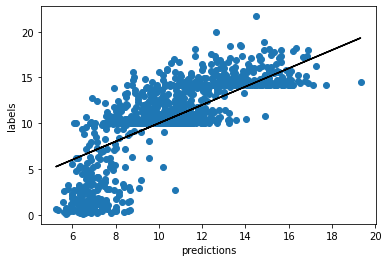

In [ ]:
#plot the labels vs preds.
import numpy as np
from matplotlib import pyplot as plt

preds = np.array([float(x.rstrip().split("\t")[-1])
                  for x in open("regression_test_preds.txt")])
labels = np.array([float(x.rstrip().split("\t")[-1])
                  for x in open("nonoise_test_labels.txt")])

plt.scatter(preds, labels)
plt.plot(preds, preds, color="black")
plt.xlabel("predictions")
plt.ylabel("labels")
plt.show()

In [ ]:
#Compute gkmexplain importance scores on a handful of regions
!head -20 trimmed_test_simulation.fa > toexplain_test_simulation.fa
!rlsgkm/bin/gkmexplain toexplain_test_simulation.fa regression.model.txt imp_toexplain_test_simulation.txt

INFO 2020-08-27 17:37:03: Number of threads is set to 1
INFO 2020-08-27 17:37:03: load model regression.model.txt
INFO 2020-08-27 17:37:03: reading... 1000/4497
INFO 2020-08-27 17:37:03: reading... 2000/4497
INFO 2020-08-27 17:37:03: reading... 3000/4497
INFO 2020-08-27 17:37:03: reading... 4000/4497
INFO 2020-08-27 17:37:04: write prediction result to imp_toexplain_test_simulation.txt
INFO 2020-08-27 17:37:05: 10 scored


In [ ]:
#read in the importance scores
impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("imp_toexplain_test_simulation.txt")
]

In [ ]:
!pip install vizsequence

  Created wheel for vizsequence: filename=vizsequence-0.1.1.0-cp36-none-any.whl size=3269 sha256=e1fce924c54b45ebd62b1069bbaa154191bf8354614d0214d83adf005a8d9b6e
  Stored in directory: /root/.cache/pip/wheels/08/eb/de/6b398b439ba39c278e5c341bdeed57d66280910e096496eaef
Successfully built vizsequence


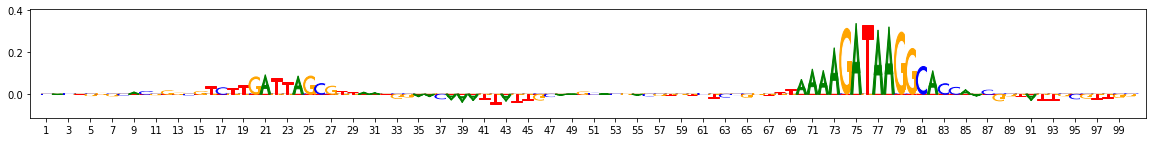

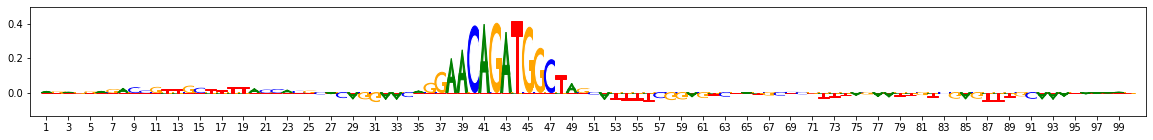

In [ ]:
#visualize importance scores on a couple of sequences, as a sanity check
import vizsequence
vizsequence.viz_sequence.plot_weights(impscores[2])
vizsequence.viz_sequence.plot_weights(impscores[3])